In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from wordcloud import WordCloud, STOPWORDS

import string
from string import punctuation
from matplotlib import style

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### In this section, I merged all of my datasets and created:
1. 2019/2020 CB vs Non-CB headline dataset (20,000)
    - non-CB data pulled from API and webscraped from NY Times, The Washington Post, The Guardian, Bloomberg, and Reuters 
    - CB data pulled from 6 Twitter profiles (Buzzfeed, Examiner, ThePoliticalInsider, Upworthy, BoredPanda, The Odyssey
    - features - text, class, date
2. 2007 - 2016 CB vs Non-CB headline dataset (30,000)
    - from Kaggle 
    - Non-CB: NY Times, The Guardian, The Hindu, Wikinews
    - CB: BuzzFeed, Upworthy, ViralNova, Thatscoop, Scoopwhoop and ViralStories
    - text, class
3. One total dataset combining both (50,000)
    - text headlines, class

In [5]:
#reading in datasets
clickbait_df=pd.read_csv('clickbait_final.csv',index_col=0)
nytimes_df=pd.read_csv('nytimes_data_final.csv',index_col=0)
guardian_df=pd.read_csv('guardian_headlines.csv',index_col=0)
twp_df=pd.read_csv('TWP_scraped.csv',index_col=0)
reuters_df=pd.read_csv('reuters_100.csv',index_col=0)
bloomberg_df=pd.read_csv('bloomberg_100.csv',index_col=0)

In [56]:
#labeling class to 1 for all clickbait headlines
clickbait_df['class']=1
clickbait_df.shape

(11116, 3)

In [57]:
#labeling 'class' to 0 for non clickbait headlines
nytimes_df['class']=0
nytimes_df.shape

(5299, 3)

In [58]:
guardian_df['class']=0
guardian_df.shape

(3400, 3)

In [36]:
twp_df.rename(columns={'title':"text",'published':'date'},inplace=True)
twp_df['class']=0

In [37]:
reuters_df['class']=0

In [38]:
bloomberg_df['class']=0

In [39]:
all_headlines_df=pd.concat([clickbait_df,nytimes_df,guardian_df,twp_df,reuters_df,bloomberg_df])

In [54]:
all_headlines_df.shape

(20172, 3)

In [60]:
#all_headlines_df.to_csv('2019_2020_all_headlines.csv')

In [71]:
all_headlines_df.drop(columns='date',inplace=True)

In [61]:
dataset2=pd.read_csv('2007_2016_headline_data.csv')

In [68]:
dataset2.rename(columns={'headline':'text','clickbait':'class'},inplace=True)

In [69]:
dataset2

,text,class
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [72]:
df = pd.concat([all_headlines_df,dataset2])

In [74]:
df.shape

(52172, 2)

In [75]:
df['class'].value_counts()

1    27115
0    25057
Name: class, dtype: int64

In [79]:
#df.to_csv('total_headlines.csv')


In [593]:
df['class'].value_counts()

1    27115
0    25057
Name: class, dtype: int64

### In this section, I process the dataset for EDA and create additional features: 

In [664]:
df = pd.read_csv('total_headlines.csv')

In [665]:
#make text lowercase
df['text']=df['text'].apply(lambda x: x.lower())

In [543]:
#function to remove punctuation and non-alphabetical characters and links
import re
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    #text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('“','',text)
    text = re.sub('”','',text)
    text = re.sub('’','',text)
    text = re.sub('–','',text)
    text = re.sub('‘','',text)
    
    return text

In [666]:
#function to find if string contains a question and if so, update new feature with a 1 for yes or 0 for no
question_words = ['who','what','where','why','when','whose','whom','would','will','how','which','should','could']

def contains_question(headline):
    if "?" in headline or headline.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
        return 1
    else: 
        return 0

df['question_6']=df['text'].apply(contains_question)


In [332]:
#test
#df['text'][0].startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','trey'))

In [667]:
df.rename(columns={'question_6':'question'},inplace=True)

In [668]:
df['question'].value_counts()

0    47388
1     4784
Name: question, dtype: int64

In [669]:
#create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
def contains_exclamation(headline):
    if "!" in headline: 
        return 1
    else: 
        return 0
df['exclamation']=df['text'].apply(contains_exclamation)

In [670]:
df.exclamation.value_counts()

0    51614
1      558
Name: exclamation, dtype: int64

In [671]:
#clean headlines to remove puncuation and links
#create feature to count words of each (before removing stop words and numbers)
#create feature to count if headline starts with a digit or not

feature_engineering_clean = lambda x: clean_text_round1(x)
df.text = pd.DataFrame(df.text.apply(feature_engineering_clean))


#create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
def starts_with_num(headline):
    if headline.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

df['starts_with_num']=df['text'].apply(starts_with_num)

In [672]:
df.drop(columns='Unnamed: 0',inplace=True)

In [673]:
#create feature that counts words in each headline
df['headline_words'] = df['text'].apply(lambda x: len(x.split()))

In [675]:
df = df[df['headline_words'] != 0]
df

,text,class,question,exclamation,starts_with_num,headline_words
0,trey gowdy just humiliated adam schiff in fron...,1,0,0,0,10
1,60 netflix titles leaving in july 2020,1,0,0,1,7
2,learn how to make a green grape taste like a j...,1,0,1,0,22
3,the new july netflix titles are here and there...,1,0,0,0,13
4,the courts say sex discrimination laws protect...,1,0,0,0,19
...,...,...,...,...,...,...
52167,to make female hearts flutter in iraq throw a ...,0,0,0,0,10
52168,british liberal democrat patsy calton 56 dies ...,0,0,0,0,9
52169,drone smartphone app to help heart attack vict...,0,0,0,0,12
52170,netanyahu urges pope benedict in israel to den...,0,0,0,0,9


In [676]:
df.to_csv('with_engineeredfeat_data.csv')

# EDA 

In [3]:
#cleaning data to remove stopwords & tokenize text for EDA

df=pd.read_csv('data/with_engineeredfeat_data.csv')

def tokenize(text):
    text = [word_tokenize(x) for x in text]
    return text

df.text = tokenize(df.text)

stopwords_list = stopwords.words('english')
df.text = df['text'].apply(lambda x: [item for item in x if item not in stopwords_list])


In [4]:
#creating seperate dataframes for each class
df_cb=df[df['class']==1]

In [5]:
df_noncb=df[df['class']==0]

In [6]:
#creating a list of unique words for each class
cb_list=list(df_cb['text'])

total_vocab_cb = set()
for word in cb_list:
    total_vocab_cb.update(word)
len(total_vocab_cb)

20291

In [7]:
noncb_list=list(df_noncb['text'])

total_vocab_noncb = set()
for word in noncb_list:
    total_vocab_noncb.update(word)
len(total_vocab_noncb)

23485

In [8]:

flat_cb = [item for sublist in cb_list for item in sublist]
flat_noncb = [item for sublist in noncb_list for item in sublist]


cb_freq = FreqDist(flat_cb)
noncb_freq = FreqDist(flat_noncb)


In [683]:
#top 20 clickbait words 
cb_freq.most_common(20)

[('people', 1745),
 ('things', 1416),
 ('make', 1038),
 ('know', 1005),
 ('new', 947),
 ('like', 809),
 ('17', 785),
 ('best', 733),
 ('actually', 730),
 ('21', 706),
 ('times', 658),
 ('based', 650),
 ('get', 644),
 ('need', 644),
 ('19', 640),
 ('coronavirus', 632),
 ('life', 591),
 ('heres', 586),
 ('one', 585),
 ('trump', 565)]

In [684]:
#top 20 non-clickbait words 
noncb_freq.most_common(20)

[('us', 1483),
 ('new', 1259),
 ('police', 598),
 ('uk', 545),
 ('says', 501),
 ('dies', 492),
 ('coronavirus', 459),
 ('election', 432),
 ('trump', 423),
 ('dead', 404),
 ('first', 381),
 ('killed', 373),
 ('results', 339),
 ('china', 337),
 ('president', 330),
 ('court', 325),
 ('primary', 322),
 ('two', 319),
 ('world', 316),
 ('australian', 308)]

In [10]:
# create counts of clickbait and non-clickbait words and values
cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

noncb_bar_counts = [x[1] for x in noncb_freq.most_common(20)]
noncb_bar_words = [x[0] for x in noncb_freq.most_common(20)]

plt.style.use('seaborn-talk')

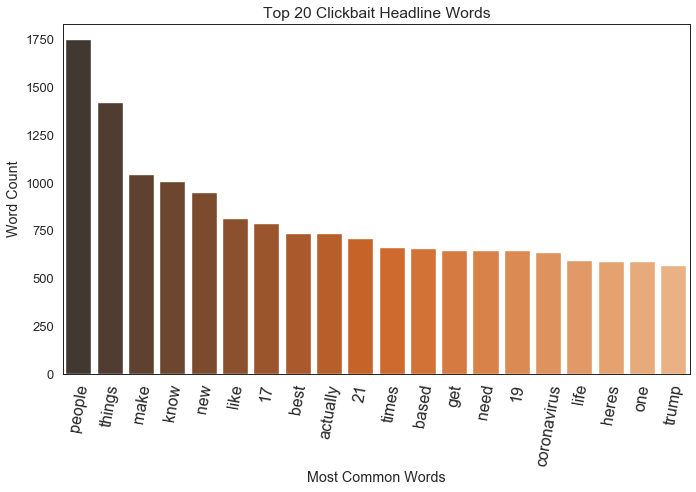

In [689]:
#bar plot for top 15 most common clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style('white')
plt.show()

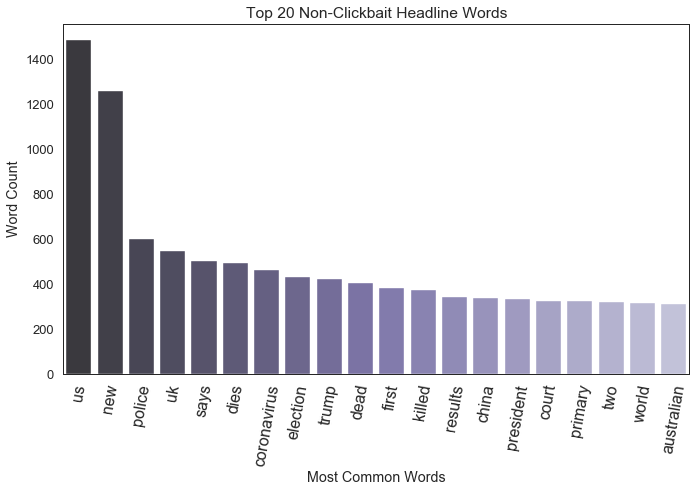

In [690]:
#bar plot for top 15 most common non-clickbait words
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(noncb_bar_words, noncb_bar_counts,palette='Purples_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 Non-Clickbait Headline Words')
plt.xlabel('Most Common Words')
plt.ylabel('Word Count')
sns.set_style()
plt.show()

In [11]:
# Getting data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
clickbait_dictionary = dict(zip(cb_bar_words, cb_bar_counts))
nonclickbait_dictionary = dict(zip(noncb_bar_words, noncb_bar_counts))


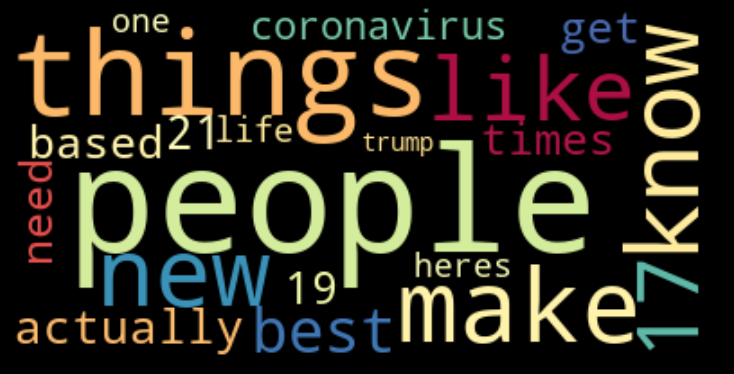

In [694]:
# Create the clickbait word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(clickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:

plt.savefig('clickbait_wc')

plt.show()

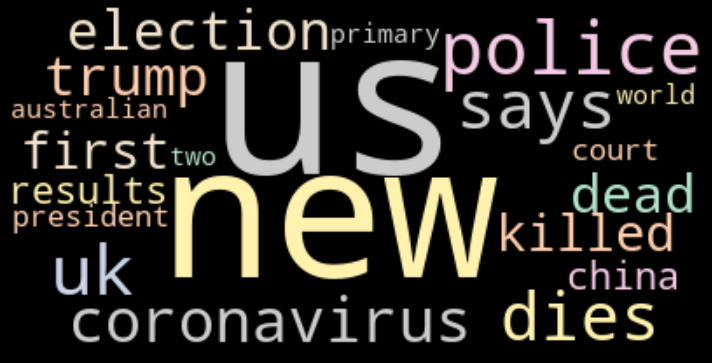

In [12]:
# Create the non-clickbait word cloud:

wordcloud = WordCloud(colormap='Pastel2').generate_from_frequencies(nonclickbait_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
plt.tight_layout()
plt.savefig('noncb_wc')

plt.show()

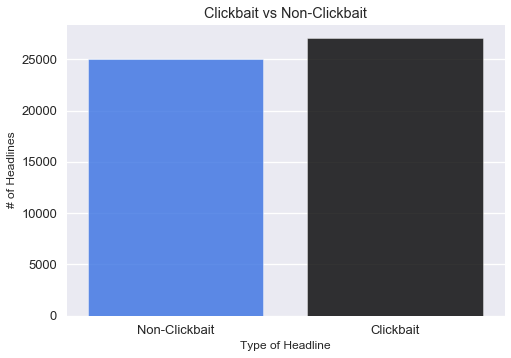

In [719]:
#class variable countplot
#visualizing class frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df['class'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('Clickbait vs Non-Clickbait')
plt.ylabel('# of Headlines')
plt.xlabel('Type of Headline')
fig1.set(xticklabels=['Non-Clickbait','Clickbait'])
plt.tight_layout()
plt.savefig('class_dist')
plt.show()


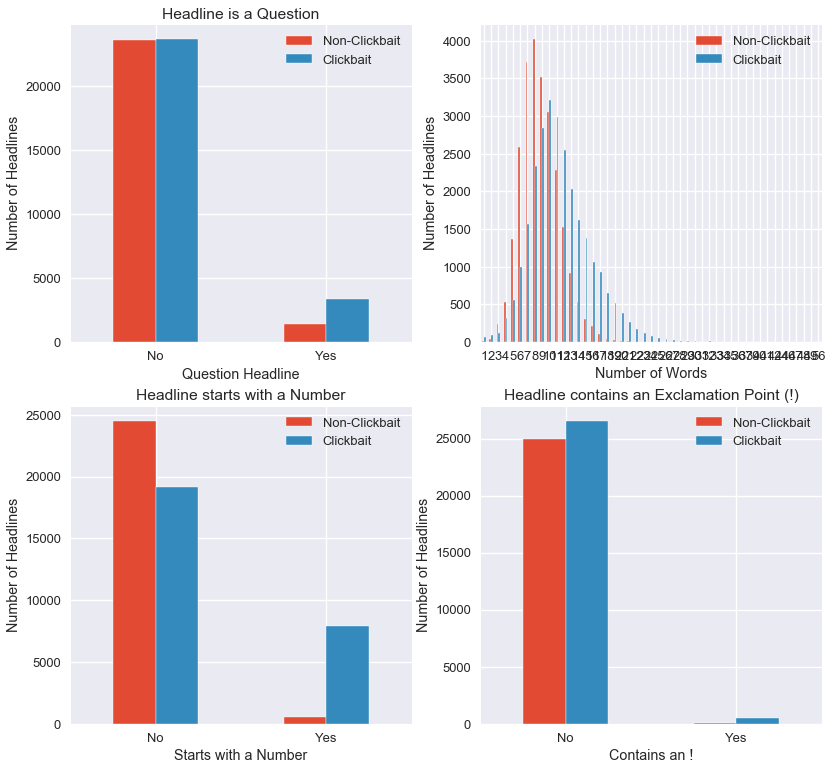

In [748]:
#plotting engineered features to compare by class 
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline is a Question')

plot = df.groupby('headline_words')['class'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])


plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline starts with a Number')

plot = df.groupby('exclamation')['class'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plot.set_title('Headline contains an Exclamation Point (!)')

style.use('ggplot')
plt.show()



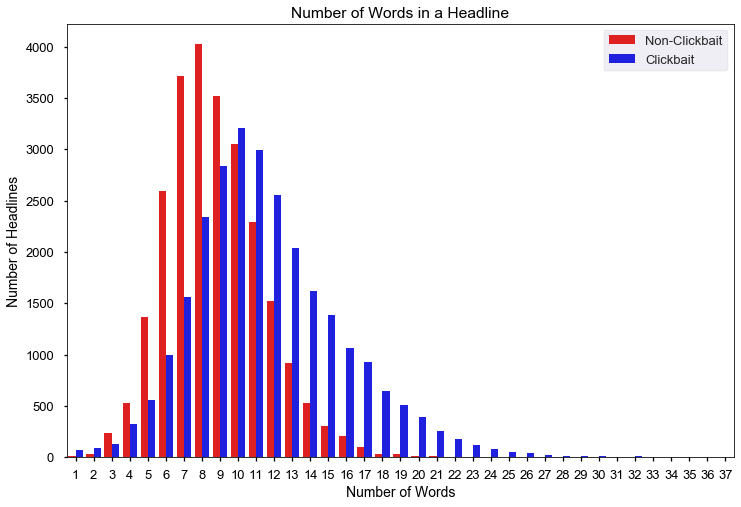

In [18]:
#replotting headline word comparison plot with smaller range

df_words = df[df['headline_words'] < 38]

sns.countplot(df_words['headline_words'],hue=df_words['class'],palette=['red','blue'],data=df_words)
sns.set_style('darkgrid')
plt.xlabel('Number of Words',size=14)
plt.ylabel('Number of Headlines', size=14)
plt.legend(title=None,labels=['Non-Clickbait','Clickbait'],loc='upper right')
plt.title('Number of Words in a Headline')
plt.tight_layout()
#plt.savefig('num_words_comparison')

plt.show()

In [776]:
df['class'].value_counts()

1    27070
0    25057
Name: class, dtype: int64

Text(0.5, 1, 'Headline is a Question')

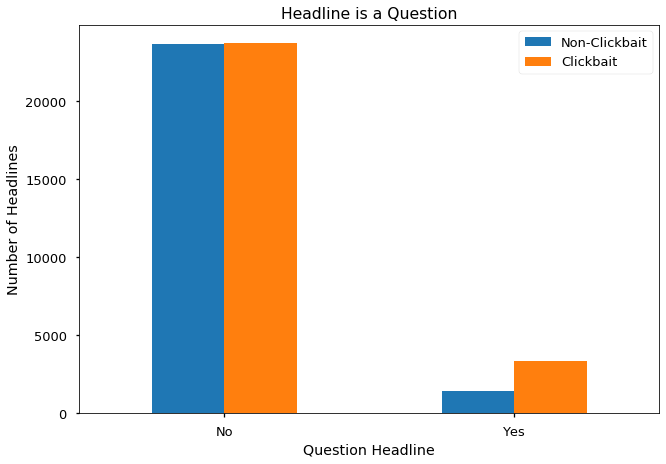

In [15]:
plot = df.groupby('question')['class'].value_counts().unstack().plot.bar(rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plt.savefig('question2')
plot.set_title('Headline is a Question')

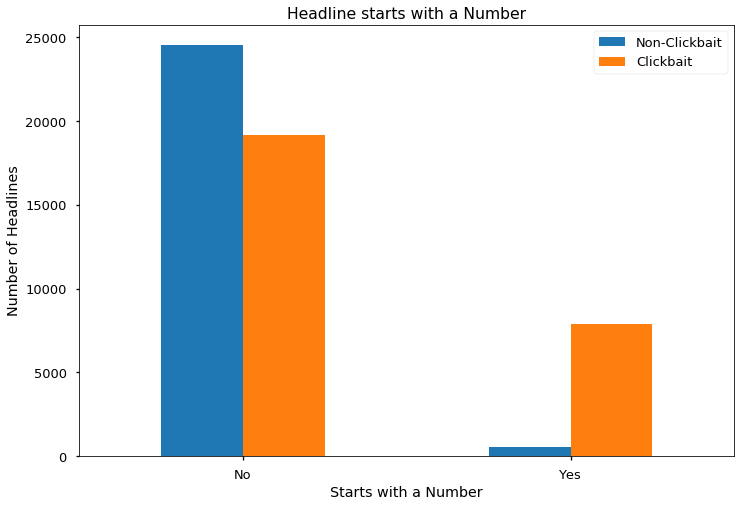

In [17]:
plot = df.groupby('starts_with_num')['class'].value_counts().unstack().plot.bar(rot=0)
plot.set_xlabel('Starts with a Number')
plot.set_ylabel('Number of Headlines')
plot.legend(title=None,labels=['Non-Clickbait','Clickbait'])
plot.set(xticklabels=['No','Yes'])
plt.savefig('numstart')
plot.set_title('Headline starts with a Number')
plt.tight_layout()
plt.show()